In [42]:
import glob
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import plot_confusion_matrix

sns.set_style('darkgrid')
%matplotlib inline

In [43]:
# data prep and model-tuning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.feature_selection import SelectFromModel
from skopt import BayesSearchCV
from sklearn.metrics import (make_scorer, cohen_kappa_score, 
                             precision_recall_curve, confusion_matrix, 
                             plot_precision_recall_curve, precision_score, 
                             recall_score, f1_score)

# types of models we'll fit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# for saving things
import pickle
# skopt generates warnings if the same parameter set is sampled again
import warnings

In [44]:
from sklearn.calibration import calibration_curve
from imblearn.metrics import classification_report_imbalanced, sensitivity_specificity_support

## Our Data

In [45]:
DATA = '../data/processed/monthly_species_training.csv'
df = pd.read_csv(DATA)
print('{:,d} samples'.format(len(df)))
print('Columns:', df.columns.values)

11,832 samples
Columns: ['lat' 'lon' 'orig_id' 'uuid' 'source' 'meas_yr' 'ecoregion3' 'agency'
 'plot_size_ac' 'year' 'tmax01' 'tmax02' 'tmax03' 'tmax04' 'tmax05'
 'tmax06' 'tmax07' 'tmax08' 'tmax09' 'tmax10' 'tmax11' 'tmax12' 'tmin01'
 'tmin02' 'tmin03' 'tmin04' 'tmin05' 'tmin06' 'tmin07' 'tmin08' 'tmin09'
 'tmin10' 'tmin11' 'tmin12' 'tave01' 'tave02' 'tave03' 'tave04' 'tave05'
 'tave06' 'tave07' 'tave08' 'tave09' 'tave10' 'tave11' 'tave12' 'ppt01'
 'ppt02' 'ppt03' 'ppt04' 'ppt05' 'ppt06' 'ppt07' 'ppt08' 'ppt09' 'ppt10'
 'ppt11' 'ppt12' 'dd_0_01' 'dd_0_02' 'dd_0_03' 'dd_0_04' 'dd_0_05'
 'dd_0_06' 'dd_0_07' 'dd_0_08' 'dd_0_09' 'dd_0_10' 'dd_0_11' 'dd_0_12'
 'dd5_01' 'dd5_02' 'dd5_03' 'dd5_04' 'dd5_05' 'dd5_06' 'dd5_07' 'dd5_08'
 'dd5_09' 'dd5_10' 'dd5_11' 'dd5_12' 'dd_18_01' 'dd_18_02' 'dd_18_03'
 'dd_18_04' 'dd_18_05' 'dd_18_06' 'dd_18_07' 'dd_18_08' 'dd_18_09'
 'dd_18_10' 'dd_18_11' 'dd_18_12' 'dd18_01' 'dd18_02' 'dd18_03' 'dd18_04'
 'dd18_05' 'dd18_06' 'dd18_07' 'dd18_08' 'dd18_09' 

In [46]:
# filter out some outliers (detected based on major difference between lidar height and field-measured height)
outliers = pd.read_csv('../data/interim/outlier_uuids.csv')
outliers.head()

,outlier_uuid
0,01ef37b1-899f-49c3-9031-127995694ea0
1,0228e3ed-e7a0-4053-ac38-4abe9c84e214
2,02e702cb-65c1-4c95-a271-8a815419965f
3,05bd7e12-fd98-4358-83bc-cc2c0f9dde83
4,0636e7b4-f206-420c-8b62-d9e72c0295fa


In [49]:
df = df.loc[~df.uuid.isin(outliers.outlier_uuid)].reset_index(drop=True)

In [50]:
# df['year_diff'] = abs(df['year'] - df['meas_yr'])
# df = df.loc[df.groupby(by=['uuid'])['year_diff'].idxmin()]
# df.info()

The different types of predictor variables we will use to predict forest composition, including climate, soil, and satellite-derived attributes.

In [51]:
# calculate cumulative degree days above 5C each year
dd5_cols = [col for col in df.columns if col.startswith('dd5')]
dd5_cum_cols = [col + '_cum' for col in dd5_cols]
df[dd5_cum_cols] = df[dd5_cols].cumsum(axis=1)

In [52]:
# calculate cumulative degree days below 0C each year
dd_0_cols = ['dd_0_10', 'dd_0_11', 'dd_0_12', 'dd_0_01', 'dd_0_02', 'dd_0_03']
dd_0_cum_cols = [col + '_cum' for col in dd_0_cols]
df[dd_0_cum_cols] = df[dd_0_cols].cumsum(axis=1)

In [53]:
# calculate cumulative degree days above 5C each year
dd5_cols = [col for col in df.columns if col.startswith('dd5')]
dd5_cum_cols = [col + '_cum' for col in dd5_cols]
df[dd5_cum_cols] = df[dd5_cols].cumsum(axis=1)

# calculate cumulative degree days below 0C each year
dd_0_cols = ['dd_0_10', 'dd_0_11', 'dd_0_12', 'dd_0_01', 'dd_0_02', 'dd_0_03']
dd_0_cum_cols = [col + '_cum' for col in dd_0_cols]
df[dd_0_cum_cols] = df[dd_0_cols].cumsum(axis=1)

# calculate cumulative degree days above 5C each year
cmd_cols = [col for col in df.columns if col.startswith('cmd')]
cmd_cum_cols = [col + '_cum' for col in cmd_cols]
df[cmd_cum_cols] = df[cmd_cols].cumsum(axis=1)

In [54]:
# for using monthly climate attributes
CLIM_COLS = [
    # cumulative growing degree days above 5C in spring
    'dd5_03_cum', 'dd5_04_cum', 'dd5_05_cum',  
    
    # cumulative chilling degree days below 0C in late fall and winter months
    'dd_0_11_cum', 'dd_0_12_cum', 'dd_0_01_cum', 'dd_0_02_cum', 'dd_0_03_cum', 
    
    # cumulative climatic moisture deficit during growing season
    'cmd05_cum', 'cmd06_cum', 'cmd07_cum', 'cmd08_cum', 
]


SOIL_COLS = ['bulk_dens', 'soil_depth', 'pct_clay_surf', 'pct_rock_surf', 'pct_sand_surf']

LANDSAT_COLS = ['green', 'blue', 'red', 'nir', 'endvi', 'ndvi', 'savi',
                'swir1', 'swir2', 'wetness', 'greenness', 'brightness']

MODIS_COLS = ['dormancy', 'evi_amplitude', 'evi_area', 'evi_minimum',
              'greenup', 'maturity', 'midgreendown', 'midgreenup', 
              'peak',
#              'numcycles'
             ]

In [55]:
RANDOM_STATE = 19831207

## Selecting initial features and targets
This is the first step in determining what features we want to use, and what we want to predict. Later, we can still apply some procedures to choose a subset of these features to make simpler models.

Now we can apply this threshold to all the species-group-level basal areas for the plots to create a binary presence/absence classification for each species group on each plot. 

In [56]:
BA_COLS = ['TRUE_FIR', 'OTHER_HARDWOOD', 'MAPLE', 'OAK', 'DOUGLAS_FIR', 
           'SPRUCE', 'CEDAR', 'PONDEROSA_PINE', 'OTHER_SOFTWOOD', 
           'LODGEPOLE_PINE', 'HEMLOCK', 'RED_ALDER', 'TANOAK', 'JUNIPER',
           'LARCH']

pres_cols = [x + '_pres' for x in BA_COLS]
spp_presence = (df[BA_COLS].values.reshape(-1,1) > 0).reshape(df[BA_COLS].shape)*1
spp_presence = pd.DataFrame(data=spp_presence, columns=pres_cols)

We'll use the following classification of abundance for each species:

| label | description | basal area |  
| :--: | :--: | :--: |
| 0 | absent | 0% |  
| 1 | present | (0-33%] |  
| 2 | abundant | (33-66%] |
| 3 | dominant | (66-100%] |

In [57]:
ba_prop = df[BA_COLS].divide(df[BA_COLS].sum(axis=1) + 1e-9, axis=0)
prop_cols = [x + '_prop' for x in BA_COLS]
ba_prop.columns = prop_cols

SW_SPP = ['TRUE_FIR', 'DOUGLAS_FIR', 'SPRUCE', 'CEDAR', 
          'PONDEROSA_PINE', 'OTHER_SOFTWOOD', 'LODGEPOLE_PINE', 
          'HEMLOCK', 'JUNIPER', 'LARCH']
SW_PROP_COLS = [spp+'_prop' for spp in SW_SPP]
HW_SPP = ['OTHER_HARDWOOD','MAPLE', 'OAK', 'RED_ALDER', 'TANOAK']
HW_PROP_COLS = [spp+'_prop' for spp in HW_SPP]

ba_prop['ALL_HARDWOOD_prop'] = ba_prop[HW_PROP_COLS].sum(axis=1)
ba_prop['ALL_SOFTWOOD_prop'] = ba_prop[SW_PROP_COLS].sum(axis=1)
# prop_cols.extend(['ALL_HARDWOOD_prop', 'ALL_SOFTWOOD_prop'])

abund_cols = [x + '_abund' for x in BA_COLS]
# abund_cols.extend(['ALL_HARDWOOD_abund', 'ALL_SOFTWOOD_abund'])

spp_abund = pd.DataFrame(data=np.digitize(ba_prop[prop_cols].values, [0,1/3,2/3], right=True), 
                         index=ba_prop.index,
                         columns=abund_cols)

In [58]:
spp_abund['HARDWOOD_SOFTWOOD_abund'] = np.nan

# hardwood dominance, no softwood presence
spp_abund.loc[(ba_prop['ALL_HARDWOOD_prop'] > 0.66) & 
              (np.isclose(ba_prop['ALL_SOFTWOOD_prop'], 0)),
              'HARDWOOD_SOFTWOOD_abund'] = -3

# hardwood dominance, softwood presence
spp_abund.loc[(ba_prop['ALL_HARDWOOD_prop'] > 0.66) & 
              (ba_prop['ALL_SOFTWOOD_prop'] > 0),
              'HARDWOOD_SOFTWOOD_abund'] = -2

# hardwood (moreso) and softwood abundant, neither dominant
spp_abund.loc[(ba_prop['ALL_HARDWOOD_prop'] > 0.33) & 
              (ba_prop['ALL_SOFTWOOD_prop'] > 0.33) & 
              (ba_prop['ALL_HARDWOOD_prop'] > ba_prop['ALL_SOFTWOOD_prop']),
              'HARDWOOD_SOFTWOOD_abund'] = -1

# no basal area recorded, nonstocked
spp_abund.loc[np.isclose(ba_prop['ALL_HARDWOOD_prop'],0) & 
              np.isclose(ba_prop['ALL_SOFTWOOD_prop'],0),
              'HARDWOOD_SOFTWOOD_abund'] = -9998

# softwood and hardwood equal at 50%
spp_abund.loc[np.isclose(ba_prop['ALL_SOFTWOOD_prop'], ba_prop['ALL_HARDWOOD_prop']) & 
              (ba_prop['ALL_SOFTWOOD_prop'] > 0),
              'HARDWOOD_SOFTWOOD_abund'] = 0

# softwood (moreseo) and hardwood abundant, neither dominant
spp_abund.loc[(ba_prop['ALL_SOFTWOOD_prop'] > 0.33) & 
              (ba_prop['ALL_HARDWOOD_prop'] > 0.33) & 
              (ba_prop['ALL_SOFTWOOD_prop'] > ba_prop['ALL_HARDWOOD_prop']),
              'HARDWOOD_SOFTWOOD_abund'] = 1

# softwood dominance, hardwood presence
spp_abund.loc[(ba_prop['ALL_SOFTWOOD_prop'] > 0.66) & 
              (ba_prop['ALL_HARDWOOD_prop'] > 0),
              'HARDWOOD_SOFTWOOD_abund'] = 2

# softwood dominance, no hardwood presence
spp_abund.loc[(ba_prop['ALL_SOFTWOOD_prop'] > 0.66) & 
              (np.isclose(ba_prop['ALL_HARDWOOD_prop'], 0)),
              'HARDWOOD_SOFTWOOD_abund'] = 3



spp_abund['HARDWOOD_SOFTWOOD_abund'] = spp_abund['HARDWOOD_SOFTWOOD_abund'].astype(int)

In [59]:
spp_df = pd.concat([ba_prop, spp_abund], axis=1)
spp_df.head()

,TRUE_FIR_prop,OTHER_HARDWOOD_prop,MAPLE_prop,OAK_prop,DOUGLAS_FIR_prop,SPRUCE_prop,CEDAR_prop,PONDEROSA_PINE_prop,OTHER_SOFTWOOD_prop,LODGEPOLE_PINE_prop,...,CEDAR_abund,PONDEROSA_PINE_abund,OTHER_SOFTWOOD_abund,LODGEPOLE_PINE_abund,HEMLOCK_abund,RED_ALDER_abund,TANOAK_abund,JUNIPER_abund,LARCH_abund,HARDWOOD_SOFTWOOD_abund
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.096639,0.000000,...,0,0,1,0,3,0,0,0,0,3
1,0.687861,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.098266,0.005780,...,0,0,1,1,1,0,0,0,0,3
2,0.688235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.100000,0.005882,...,0,0,1,1,1,0,0,0,0,3
3,0.690058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.099415,0.005848,...,0,0,1,1,1,0,0,0,0,3
4,0.686047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.098837,0.005814,...,0,0,1,1,1,0,0,0,0,3


In [60]:
# merge these presence and abundance classes into the dataframe
df = pd.concat([df, spp_df], axis=1)
df.head()

,lat,lon,orig_id,uuid,source,meas_yr,ecoregion3,agency,plot_size_ac,year,...,CEDAR_abund,PONDEROSA_PINE_abund,OTHER_SOFTWOOD_abund,LODGEPOLE_PINE_abund,HEMLOCK_abund,RED_ALDER_abund,TANOAK_abund,JUNIPER_abund,LARCH_abund,HARDWOOD_SOFTWOOD_abund
0,43.631354,-121.946826,060105045220239,df4c7f9d-666a-4543-bf08-b6e849bb3bff,USFS-BLUE-MOUNTAINS,2015,cascades,USFS,0.25,2016,...,0,0,1,0,3,0,0,0,0,3
1,43.926278,-121.822672,060105053830240,482d6afb-a0df-4114-a199-193f2907760b,USFS-BLUE-MOUNTAINS,2015,cascades,USFS,0.25,2014,...,0,0,1,1,1,0,0,0,0,3
2,43.926278,-121.822672,060105053830240,482d6afb-a0df-4114-a199-193f2907760b,USFS-BLUE-MOUNTAINS,2015,cascades,USFS,0.25,2015,...,0,0,1,1,1,0,0,0,0,3
3,43.926278,-121.822672,060105053830240,482d6afb-a0df-4114-a199-193f2907760b,USFS-BLUE-MOUNTAINS,2015,cascades,USFS,0.25,2016,...,0,0,1,1,1,0,0,0,0,3
4,43.926278,-121.822672,060105053830240,482d6afb-a0df-4114-a199-193f2907760b,USFS-BLUE-MOUNTAINS,2015,cascades,USFS,0.25,2017,...,0,0,1,1,1,0,0,0,0,3


In [61]:
X_COLS = LANDSAT_COLS + CLIM_COLS\
+ ['qmd', 'total_cover', 'topht']\
+ ['distance_to_water_m', 'lat', 'lon', 'aspect', 'elevation']
# + SOIL_COLS\
# + MODIS_COLS\

## Split the data into training and testing sets
Since some plot_ids have multiple observations, we want all observations for each plot_id to fall entirely in train_set or entirely the training or testing sets because these samples are definitely not independent.

In [62]:
# create training and testing sets for each species group
train_sets = []
test_sets = []

# make sure each plot (uuid) only goes into either train or testing set
uuids = pd.unique(df['uuid'].values)
np.random.seed(RANDOM_STATE)
train0_test1 = np.random.choice((0,1), uuids.shape, p=(0.8,0.2))
train_test_assign = pd.DataFrame(np.dstack((uuids, train0_test1))[0], columns=['uuid', 'train0_test1'])
df_assigned = df.merge(train_test_assign, on='uuid')
    
train = df_assigned.loc[df_assigned['train0_test1'] == 0]
test = df_assigned.loc[df_assigned['train0_test1'] == 1]

## Standardize features
Scale all predictive features to have 0 mean and unit variance (subtracting mean, dividing by standard deviation).

In [63]:
X_train, X_test = train[X_COLS].copy(), test[X_COLS].copy()
x_scaler = StandardScaler()
x_scaler.fit(df[X_COLS])

X_train[X_COLS], X_test[X_COLS] = x_scaler.transform(X_train), x_scaler.transform(X_test)

Y_train, Y_test = train[spp_df.columns], test[spp_df.columns]

pickle.dump(x_scaler, 
            open('../models/composition/sklearn_tuned/x_scaler.pkl', 'wb'))

# Quick Look at Data
Be aware that the data are heavily skewed towards particularly widespread species like Douglas-fir, western hemlock, and red alder. There are far fewer examples, particularly of plots with other species where those species are abundant.

In [64]:
counts = df[abund_cols].apply(np.bincount, axis=0, minlength=4)
counts.columns = [col.split('_abund')[0] for col in counts.columns]
counts = counts.rename({0: 'absent', 1:'present', 2:'abundant', 3:'dominant'}, axis=0)
counts.T.sort_values(by='absent')\
.style.format('{:,d}')

,absent,present,abundant,dominant
DOUGLAS_FIR,"2,330","1,362","2,042","5,159"
HEMLOCK,"6,224","3,068",970,631
RED_ALDER,"8,023","2,068",408,394
OTHER_HARDWOOD,"8,325","2,136",259,173
CEDAR,"8,510","1,882",374,127
TRUE_FIR,"8,889","1,309",410,285
MAPLE,"9,175","1,545",135,38
PONDEROSA_PINE,"10,151",286,178,278
SPRUCE,"10,324",383,109,77
OTHER_SOFTWOOD,"10,436",425,7,25


In [65]:
counts = test[abund_cols].apply(np.bincount, axis=0, minlength=4)
counts.columns = [col.split('_abund')[0] for col in counts.columns]
counts = counts.rename({0: 'absent', 1:'present', 2:'abundant', 3:'dominant'}, axis=0)
counts.T.sort_values(by='absent')\
.style.format('{:,d}')

,absent,present,abundant,dominant
DOUGLAS_FIR,510,246,437,"1,006"
HEMLOCK,"1,288",593,198,120
RED_ALDER,"1,628",379,94,98
TRUE_FIR,"1,747",282,103,67
CEDAR,"1,750",375,54,20
OTHER_HARDWOOD,"1,762",339,71,27
MAPLE,"1,837",337,20,5
PONDEROSA_PINE,"2,044",65,44,46
SPRUCE,"2,064",94,14,27
LARCH,"2,084",66,28,21


In [66]:
df.groupby(by=['HARDWOOD_SOFTWOOD_abund'])['uuid'].count()

HARDWOOD_SOFTWOOD_abund
-9998     115
-3        362
-2        408
-1        290
 0         16
 1        576
 2       4333
 3       4793
Name: uuid, dtype: int64

## Fit some models

In [67]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.callbacks import CheckpointSaver
from skopt import dump, load

In [68]:
# borrowed directly from Jake VanderPlas
# https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KernelDensity

np.seterr(divide='ignore', invalid='ignore')
class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    
    Parameters
    ----------
    bandwidth : float
        the kernel bandwidth within each class
    kernel : str
        the kernel name, passed to KernelDensity
    """
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
        
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        return self
        
    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X)
                             for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)
        
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

In [69]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor

MODEL_SEARCH_SPACES = {
    'rf': {
        'n_estimators': Integer(50, 5000, prior='uniform'),
        'max_depth': Integer(5, 32, prior='log-uniform'),
        'max_features': Categorical(['sqrt', 'log2', None]),
        'min_samples_split': Integer(2, 20, prior='uniform'),
        'min_samples_leaf': Integer(1, 20, prior='uniform'),
    },
    'rf_reg': {
        'n_estimators': Integer(50, 5000, prior='uniform'),
        'max_depth': Integer(5, 32, prior='log-uniform'),
        'max_features': Categorical(['sqrt', 'log2', None]),
        'min_samples_split': Integer(2, 20, prior='uniform'),
        'min_samples_leaf': Integer(1, 20, prior='uniform'),
    },
    'bal_rf': { 
        'n_estimators': Integer(50, 5000, prior='uniform'),
        'max_depth': Integer(5, 32, prior='log-uniform'),
        'max_features': Categorical(['sqrt', 'log2', None]),
        'min_samples_split': Integer(2, 20, prior='uniform'),
        'min_samples_leaf': Integer(1, 20, prior='uniform'),
    },
    'log': {
        'penalty': Categorical(['l1', 'l2', 'elasticnet', 'none']),
        'multi_class': Categorical(['ovr', 'multinomial']),
        'C': Real(1e-4, 1e4, prior='uniform'),
        'l1_ratio': Real(0, 1, prior='uniform'),
    },
    'svc':{
        'C': Real(1e-3, 1e2, prior='uniform'),
        'gamma': Real(1e-3, 1, prior='uniform'),
    },
    'kde':{
        'bandwidth': Real(1e-3, 1, prior='uniform'),
        'kernel': Categorical(['gaussian', 'tophat', 'epanechnikov', 
                               'exponential', 'linear', 'cosine']),
    },
    'knn': {
        'n_neighbors': Integer(1, 2, prior='uniform'),
        'weights': Categorical(['uniform', 'distance']), 
        'p': Integer(1, 100, prior='log-uniform')
    },
}

MODEL_TYPES = {
    'rf': RandomForestClassifier(random_state=RANDOM_STATE,
                                 class_weight='balanced',
                                 n_jobs=-1),
    'rf_reg': RandomForestRegressor(random_state=RANDOM_STATE,
                                    n_jobs=-1),
    'bal_rf': BalancedRandomForestClassifier(random_state=RANDOM_STATE,
                                 class_weight='balanced',
                                 n_jobs=-1),
    'log': LogisticRegression(random_state=RANDOM_STATE,
                              class_weight='balanced',
                              solver='saga',
                              n_jobs=-1),
    'svc': SVC(random_state=RANDOM_STATE,
               class_weight='balanced',
               kernel='rbf'),
    'kde': KDEClassifier(),
    'knn': KNeighborsClassifier(n_jobs=-1)
}

In [70]:
groupkfold = GroupKFold(n_splits=3)
uuid_groups = df.reindex(X_train.index)['uuid']
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN, SMOTE
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import balanced_accuracy_score, average_precision_score

# scorer = make_scorer(geometric_mean_score) 
# scorer = make_scorer(cohen_kappa_score, weights='linear')

def cohen_kappa_adjust(y_true, y_pred, labels=None, weights=None, sample_weight=None):
    if y_pred.dtype == 'float' and y_pred.max() <= 1.0: # regression model trained on proportions
        y_true = np.digitize(y_true, [0,1/3,2/3], right=True)
        y_pred = np.digitize(y_pred, [0,1/3,2/3], right=True)
    
    elif y_pred.dtype == 'float' and y_pred.max() > 1.0: # regression model trained on abundance integers
        y_true = y_true.round().astype(int)
        y_pred = y_pred.round().astype(int)
        
    return cohen_kappa_score(y_true, y_pred, labels, weights, sample_weight)

scorer = make_scorer(cohen_kappa_adjust, weights='linear')

def tune_classifier(sp_name, model_type, samples_per_param=100, n_jobs=1, n_points=1):
    if model_type[-4:] == '_reg':
        y_train = Y_train[sp_name+'_prop']
    else:
        y_train = Y_train[sp_name+'_abund']
    
    model = MODEL_TYPES[model_type]
    search_space = {'model__{}'.format(key): value for (key, value) in MODEL_SEARCH_SPACES[model_type].items()}
    
    pipeline = Pipeline([# ('resampler', ADASYN(random_state=RANDOM_STATE, n_jobs=-1)),
                         ('model', model)])
    
    opt = BayesSearchCV(
        pipeline,
        search_space,
        n_iter=samples_per_param,
        random_state=RANDOM_STATE,
        cv=groupkfold,
        scoring=scorer,
        verbose=0,
        n_jobs=n_jobs,
        n_points=n_points,
    )
    
    # callback handler
    best_score = 0
    
    def on_step(optim_result):
        i = np.max(opt.cv_results_['rank_test_score'])
        if i % 10 == 1:
            print('\n@ sample iteration {}'.format(i), flush=True)
            
        score = opt.best_score_
        if min(opt.cv_results_['rank_test_score'][-n_points:]) == 1:
            print('','{:0.3f}'.format(score), end=' ', flush=True)
        else:
            print('.', end='', flush=True)
    
    SAVE_DIR = '../models/composition/sklearn_tuned/'
    check_pkl = '{}_{}_tuned_checkpoints.pkl'.format(sp_name, model_type)
    check_path = os.path.join(SAVE_DIR, check_pkl)
    checkpoint_saver = CheckpointSaver(check_path)

    print('Running {:,d} rounds of cross-validation.'.format(opt.total_iterations))
    print('Sampling {} parameters {} times each.'.format(len(search_space), samples_per_param))
    print('Displaying best cross-validation scores... ')
    
    with warnings.catch_warnings():  # don't issue warnings when we test the same parameter values
        warnings.filterwarnings("ignore", 
                                category=UserWarning) 
        
        # executes bayesian optimization
        _ = opt.fit(X_train, y_train, 
                    groups=uuid_groups, 
                    callback=[on_step, checkpoint_saver])
    
    opt_pkl = '{}_{}_tuned.pkl'.format(sp_name, model_type)
    opt_path = os.path.join(SAVE_DIR, opt_pkl)
    dump(opt, opt_path)
    print('Done. \nModel saved at {}\n'.format(opt_path))
    
    return opt

In [71]:
def print_classification_report(sp_name, model, 
                                target_names=['absent', 'present', 'abundant', 'dominant']):
    print(classification_report_imbalanced(
        Y_test[sp_name+'_abund'],
        model.predict(X_test),
        target_names=target_names))

To help interpret classification reports:
* `tp` is the number of true positives
* `fp` is the number of false positives, 
* `tn` is the number of true negatives 
* `fn` is the number of false negatives

**precision** is the ratio `tp / (tp + fp)`, or **the ability of the classifier not to label as positive a sample that is negative.** 

**recall** is the ratio `tp / (tp + fn)`, or **the ability of the classifier to find all the positive samples.**

**specificity** is the ratio `tn / (tn + fp)`, or **the ability of the classifier to find all the negative samples.**

In [72]:
def display_confusion(sp_name, model, 
                      labels=[0, 1, 2, 3],
                      display_labels=['Absent', 'Present', 'Abundant', 'Dominant']):
    fig, axs = plt.subplots(1,2, figsize=(12,4))
    plot_confusion_matrix(model, 
                          X_test, 
                          Y_test[sp_name+'_abund'],
                          labels=labels,
                          normalize='true',
                          display_labels=display_labels,
                          include_values=True,
                          values_format='.1%',
                          cmap='Greens', ax=axs[0])
    
    plot_confusion_matrix(model, 
                          X_test, 
                          Y_test[sp_name+'_abund'],
                          labels=labels,
                          display_labels=display_labels,
                          include_values=True,
                          values_format=',d',
                          cmap='Greens', ax=axs[1])
    axs[0].grid(False)
    axs[1].grid(False)
    plt.show();

In [73]:
def plot_rf_feature_importances(model):
    best_model = model.best_estimator_.steps[0][-1]
    importances = best_model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in best_model.estimators_],
                 axis=0)
    indices = np.argsort(importances)#[::-1]

    # Plot the feature importances of the forest
    plt.figure(figsize=(3,10))
    plt.title("Feature importances")
    plt.barh(range(X_train.shape[1]), importances[indices],
            color="r", yerr=std[indices], align="center")
    plt.yticks(range(X_train.shape[1]), X_train.columns[indices])
    plt.ylim([-1, X_train.shape[1]])
    plt.show();

In [74]:
spp_models = {spp:{} for spp in BA_COLS + ['HARDWOOD_SOFTWOOD']}

In [75]:
# max_depths = np.linspace(1, 200, 20)
# train_results = []
# val_results = []
# test_results = []
# for max_depth in max_depths:
    
#     rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1, n_estimators=100, 
#                                 max_features='sqrt', class_weight='balanced')
#     for train_index, val_index in groupkfold.split(X_train, groups=uuid_groups):
#         train_set = X_train.iloc[train_index]
#         val_set = X_train.iloc[val_index]
#         rf.fit(train_set, Y_train['HARDWOOD_SOFTWOOD_abund'].iloc[train_index])
#         train_pred = rf.predict(train_set)
#         val_pred = rf.predict(val_set)
#         train_score = cohen_kappa_score(
#             Y_train['HARDWOOD_SOFTWOOD_abund'].iloc[train_index], 
#             train_pred, weights='linear')
#         train_results.append(train_score)
        
#         val_score = cohen_kappa_score(
#             Y_train['HARDWOOD_SOFTWOOD_abund'].iloc[val_index], 
#             val_pred, weights='linear')
#         val_results.append(val_score)

# #     rf.fit(X_train, Y_train['HARDWOOD_SOFTWOOD_abund'])
# #     train_pred = rf.predict(X_train)
# #     train_score = cohen_kappa_score(
# #         Y_train['HARDWOOD_SOFTWOOD_abund'], 
# #         train_pred, weights='linear')
# #     train_results.append(train_score)
    
#     # now predict on test set
#     test_pred = rf.predict(X_test)
#     test_score = cohen_kappa_score(Y_test['HARDWOOD_SOFTWOOD_abund'], test_pred, weights='linear')
#     test_results.append(test_score)
    
# fig, ax = plt.subplots()
# ax.scatter(#max_depths,
#            np.repeat(max_depths,3), 
#            train_results, label='Train Cohen Score')
# ax.scatter(#max_depths,
#            np.repeat(max_depths,3), 
#            val_results, label='CrossVal Cohen Score')

# ax.plot(max_depths, test_results, label='Test Cohen Score')
# ax.legend()
# ax.set_ylabel('Weighted Cohen Kappa')
# ax.set_xlabel('Tree Depth')
# plt.show();

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.423 . 0.442  0.454 . 0.470 ....
@ sample iteration 11
..........
@ sample iteration 21
.....Done. 
Model saved at ../models/composition/sklearn_tuned/HARDWOOD_SOFTWOOD_rf_tuned.pkl



/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   pre       rec       spe        f1       geo       iba       sup

    HW>>>SW       0.94      1.00      1.00      0.97      1.00      1.00        16
     HW>>SW       0.33      0.46      0.97      0.39      0.67      0.42        78
      HW>SW       0.20      0.31      0.95      0.25      0.54      0.27        94
      HW=SW       0.21      0.09      0.99      0.12      0.29      0.08        58
 Nonstocked       0.00      0.00      1.00      0.00      0.00      0.00         8
      HW<SW       0.14      0.09      0.96      0.11      0.30      0.08       138
     HW<<SW       0.55      0.72      0.68      0.62      0.70      0.49       765
    HW<<<SW       0.83      0.64      0.88      0.72      0.75      0.55      1042

avg / total       0.62      0.60      0.82      0.60      0.68      0.47      2199



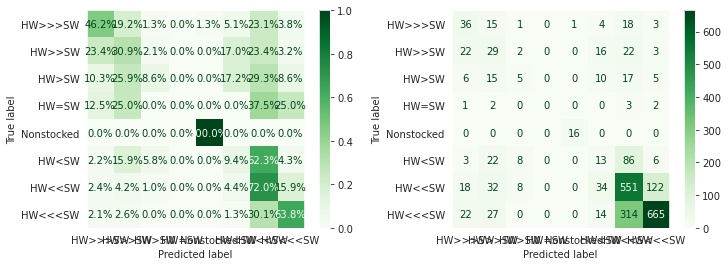

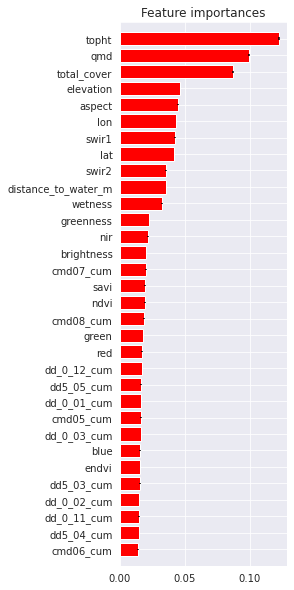

In [76]:
SP_NAME, MOD_TYPE = 'HARDWOOD_SOFTWOOD', 'rf' 

TARGET_NAMES = ['HW>>>SW', 'HW>>SW', 'HW>SW', 'HW=SW', 'Nonstocked', 'HW<SW', 'HW<<SW', 'HW<<<SW']
LABELS = [-3, -2, -1, 0, -9998, 1, 2, 3]
spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE], 
                           target_names=TARGET_NAMES)
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE],
                  labels=LABELS, display_labels=TARGET_NAMES)
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.005 .... 0.008  0.013 ...
@ sample iteration 11
 0.019  0.019  0.148 .......
@ sample iteration 21
 0.226  0.226 ...Done. 
Model saved at ../models/composition/sklearn_tuned/HARDWOOD_SOFTWOOD_bal_rf_tuned.pkl

                   pre       rec       spe        f1       geo       iba       sup

    HW>>>SW       0.89      1.00      1.00      0.94      1.00      1.00        16
     HW>>SW       0.19      0.41      0.93      0.26      0.62      0.36        78
      HW>SW       0.16      0.22      0.95      0.19      0.46      0.20        94
      HW=SW       0.03      0.12      0.91      0.05      0.33      0.10        58
 Nonstocked       0.01      0.38      0.85      0.02      0.56      0.30         8
      HW<SW       0.07      0.07      0.94      0.07      0.25      0.06       138
     HW<<SW       0.48      0.45      0.74      0.47      0.58

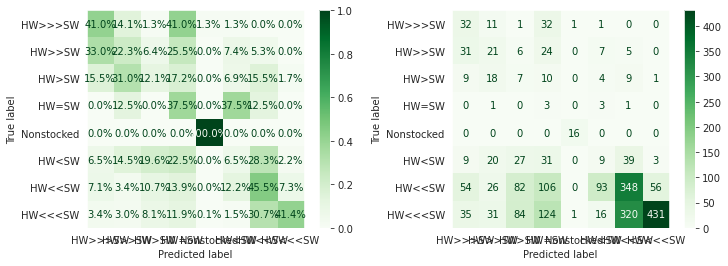

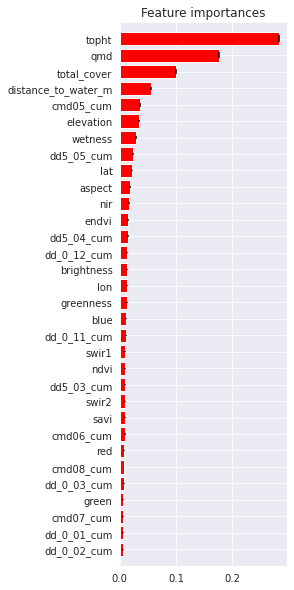

In [94]:
SP_NAME, MOD_TYPE = 'HARDWOOD_SOFTWOOD', 'bal_rf' 

TARGET_NAMES = ['HW>>>SW', 'HW>>SW', 'HW>SW', 'HW=SW', 'Nonstocked', 'HW<SW', 'HW<<SW', 'HW<<<SW']
LABELS = [-3, -2, -1, 0, -9998, 1, 2, 3]
spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE], 
                           target_names=TARGET_NAMES)
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE],
                  labels=LABELS, display_labels=TARGET_NAMES)
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])

Running 200 rounds of cross-validation.
Sampling 2 parameters 100 times each.
Displaying best cross-validation scores... 
 0.339  0.383  0.407 . 0.414 .....
@ sample iteration 51
..
@ sample iteration 61
..
@ sample iteration 71
..
@ sample iteration 81
....Done. 
Model saved at ../models/composition/sklearn_tuned/HARDWOOD_SOFTWOOD_svc_tuned.pkl

                   pre       rec       spe        f1       geo       iba       sup

    HW>>>SW       0.82      0.88      1.00      0.85      0.93      0.86        16
     HW>>SW       0.33      0.41      0.97      0.37      0.63      0.38        78
      HW>SW       0.14      0.18      0.95      0.16      0.41      0.16        94
      HW=SW       0.08      0.14      0.96      0.10      0.36      0.12        58
         NS       0.00      0.00      1.00      0.00      0.00      0.00         8
      HW<SW       0.15      0.18      0.93      0.17      0.41      0.16       138
     HW<<SW       0.58      0.62      0.76      0.60      0.69      0

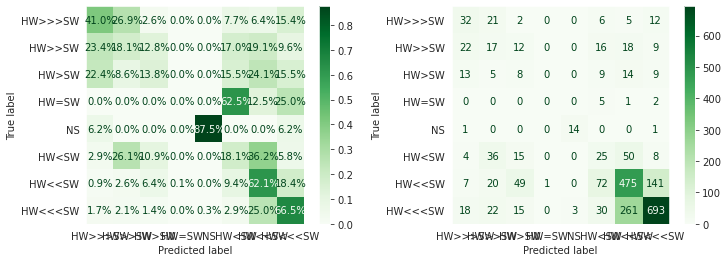

In [77]:
SP_NAME, MOD_TYPE = 'HARDWOOD_SOFTWOOD', 'svc' 

TARGET_NAMES = ['HW>>>SW', 'HW>>SW', 'HW>SW', 'HW=SW', 'NS', 'HW<SW', 'HW<<SW', 'HW<<<SW']
LABELS = [-3, -2, -1, 0, -9998, 1, 2, 3]
spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=100,
                                                n_jobs=-1, n_points=5)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE], 
                           target_names=TARGET_NAMES)
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE],
                  labels=LABELS, display_labels=TARGET_NAMES)

Running 200 rounds of cross-validation.
Sampling 4 parameters 50 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.359 .. 0.360 ......
@ sample iteration 11
.
@ sample iteration 11
.... 0.361 ....
@ sample iteration 21
..... 0.363 ....
@ sample iteration 31
...........
@ sample iteration 41
.... 0.363 ....Done. 
Model saved at ../models/composition/sklearn_tuned/HARDWOOD_SOFTWOOD_log_tuned.pkl

                   pre       rec       spe        f1       geo       iba       sup

    HW>>>SW       0.69      0.56      1.00      0.62      0.75      0.54        16
     HW>>SW       0.14      0.28      0.93      0.18      0.51      0.25        78
      HW>SW       0.21      0.26      0.96      0.23      0.49      0.23        94
      HW=SW       0.03      0.07      0.94      0.04      0.25      0.06        58
         NS       0.01      0.12      0.93      0.01      0.34      0.11         8
      HW<SW       0.10      0.10      0.94      0.10      0.31      0.09

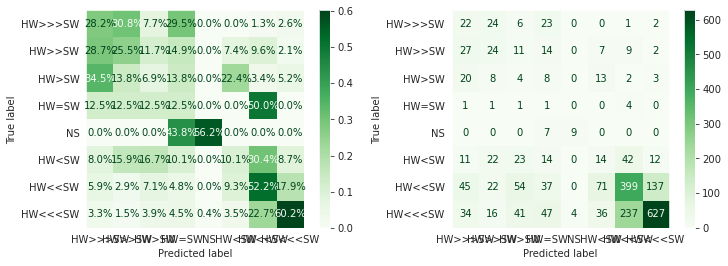

In [78]:
SP_NAME, MOD_TYPE = 'HARDWOOD_SOFTWOOD', 'log' 

TARGET_NAMES = ['HW>>>SW', 'HW>>SW', 'HW>SW', 'HW=SW', 'NS', 'HW<SW', 'HW<<SW', 'HW<<<SW']
LABELS = [-3, -2, -1, 0, -9998, 1, 2, 3]
spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=50)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE], 
                           target_names=TARGET_NAMES)
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE],
                  labels=LABELS, display_labels=TARGET_NAMES)

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.504 .. 0.511 . 0.514 ....
@ sample iteration 11
 0.515 ... 0.515 .....
@ sample iteration 21
.....Done. 
Model saved at ../models/composition/sklearn_tuned/DOUGLAS_FIR_rf_tuned.pkl

                   pre       rec       spe        f1       geo       iba       sup

     absent       0.68      0.72      0.90      0.70      0.80      0.64       510
    present       0.26      0.29      0.89      0.27      0.51      0.25       246
   abundant       0.33      0.21      0.89      0.26      0.44      0.18       437
   dominant       0.69      0.74      0.71      0.71      0.73      0.53      1006

avg / total       0.56      0.58      0.81      0.57      0.66      0.45      2199



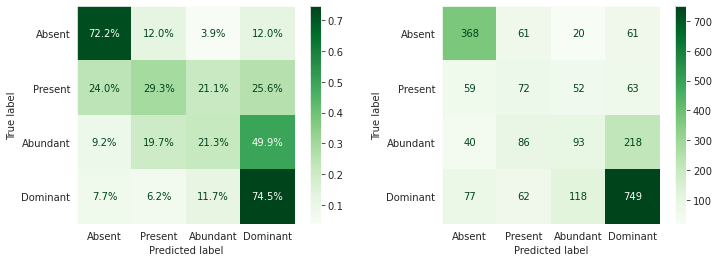

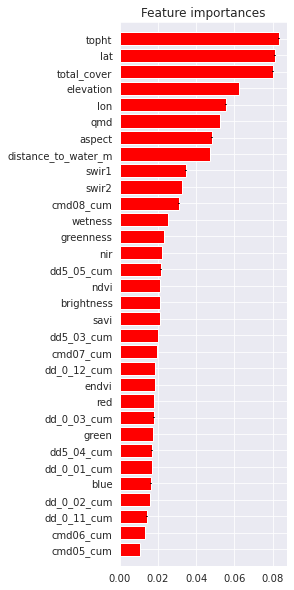

In [79]:
SP_NAME, MOD_TYPE = 'DOUGLAS_FIR', 'rf' 

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.486 .. 0.491 . 0.495 ....
@ sample iteration 11
..........
@ sample iteration 21
.....Done. 
Model saved at ../models/composition/sklearn_tuned/HEMLOCK_rf_tuned.pkl

                   pre       rec       spe        f1       geo       iba       sup

     absent       0.84      0.79      0.78      0.82      0.79      0.62      1288
    present       0.49      0.56      0.78      0.52      0.66      0.43       593
   abundant       0.29      0.22      0.95      0.25      0.46      0.19       198
   dominant       0.38      0.45      0.96      0.41      0.66      0.41       120

avg / total       0.67      0.66      0.81      0.66      0.72      0.52      2199



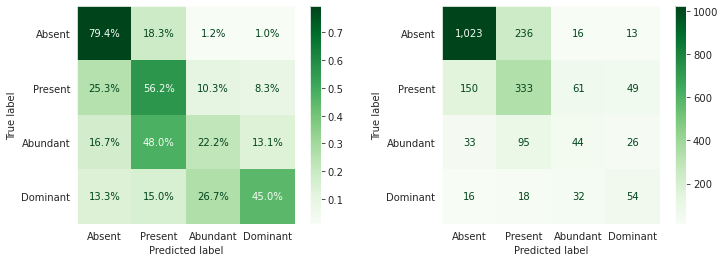

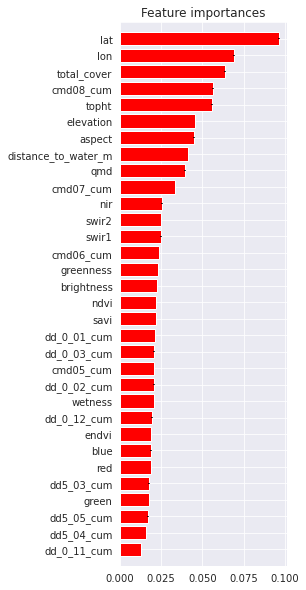

In [80]:
SP_NAME, MOD_TYPE = 'HEMLOCK', 'rf' 

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.405 .. 0.418 ......
@ sample iteration 11
...........
@ sample iteration 21
....Done. 
Model saved at ../models/composition/sklearn_tuned/RED_ALDER_rf_tuned.pkl

                   pre       rec       spe        f1       geo       iba       sup

     absent       0.87      0.79      0.67      0.83      0.73      0.54      1628
    present       0.36      0.45      0.83      0.40      0.61      0.36       379
   abundant       0.19      0.18      0.97      0.19      0.42      0.16        94
   dominant       0.32      0.48      0.95      0.38      0.68      0.43        98

avg / total       0.73      0.69      0.72      0.71      0.69      0.49      2199



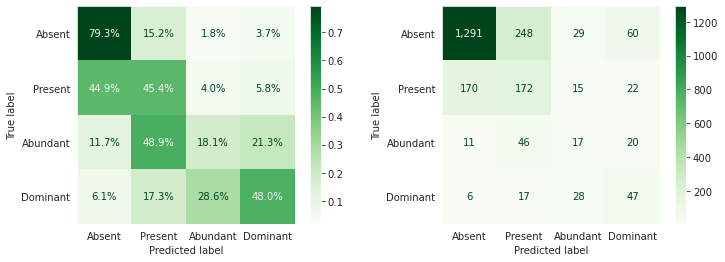

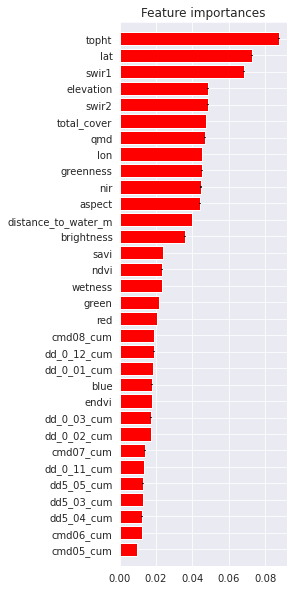

In [81]:
SP_NAME, MOD_TYPE = 'RED_ALDER', 'rf' 

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.260  0.270  0.270 .......
@ sample iteration 11
..........
@ sample iteration 21
.....Done. 
Model saved at ../models/composition/sklearn_tuned/CEDAR_rf_tuned.pkl

                   pre       rec       spe        f1       geo       iba       sup

     absent       0.86      0.84      0.45      0.85      0.62      0.40      1750
    present       0.35      0.37      0.86      0.36      0.57      0.30       375
   abundant       0.08      0.09      0.97      0.09      0.30      0.08        54
   dominant       0.00      0.00      0.99      0.00      0.00      0.00        20

avg / total       0.74      0.74      0.54      0.74      0.60      0.37      2199



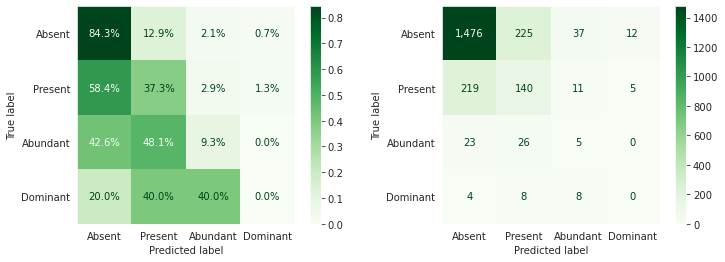

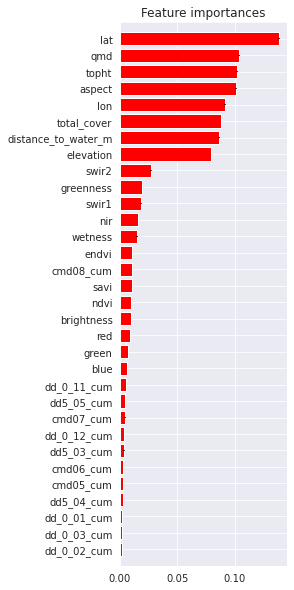

In [82]:
SP_NAME, MOD_TYPE = 'CEDAR', 'rf' 

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.499 .. 0.506 ......
@ sample iteration 11
..........
@ sample iteration 21
 0.512 ....Done. 
Model saved at ../models/composition/sklearn_tuned/MAPLE_rf_tuned.pkl

                   pre       rec       spe        f1       geo       iba       sup

     absent       0.97      0.89      0.87      0.93      0.88      0.78      1837
    present       0.58      0.86      0.89      0.69      0.87      0.76       337
   abundant       0.35      0.35      0.99      0.35      0.59      0.33        20
   dominant       0.00      0.00      1.00      0.00      0.00      0.00         5

avg / total       0.90      0.88      0.88      0.88      0.87      0.77      2199



/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


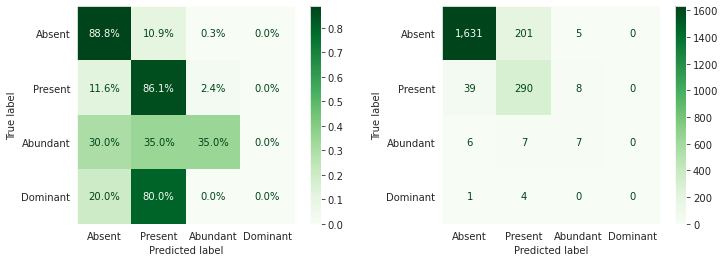

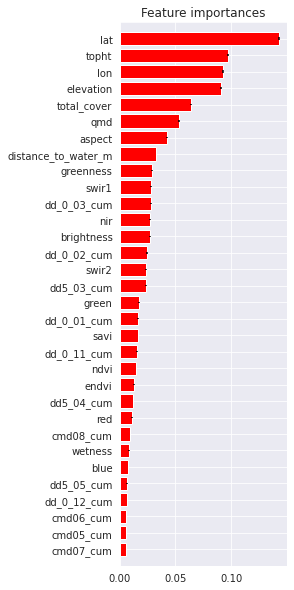

In [83]:
SP_NAME, MOD_TYPE = 'MAPLE', 'rf' 

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.472 .. 0.475 . 0.493 ....
@ sample iteration 11
..........
@ sample iteration 21
.....Done. 
Model saved at ../models/composition/sklearn_tuned/TRUE_FIR_rf_tuned.pkl

                   pre       rec       spe        f1       geo       iba       sup

     absent       0.92      0.93      0.69      0.93      0.80      0.66      1747
    present       0.43      0.34      0.93      0.38      0.57      0.30       282
   abundant       0.24      0.18      0.97      0.21      0.42      0.17       103
   dominant       0.30      0.54      0.96      0.39      0.72      0.49        67

avg / total       0.81      0.81      0.74      0.81      0.75      0.58      2199



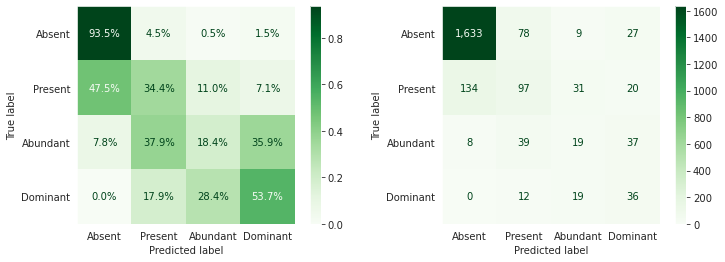

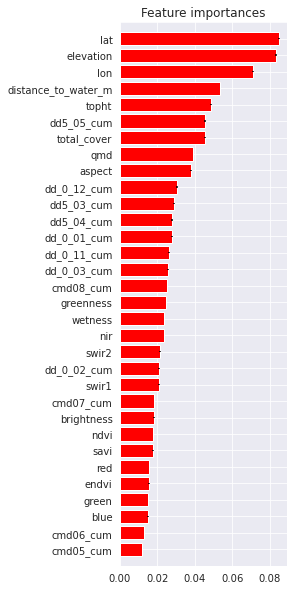

In [84]:
SP_NAME, MOD_TYPE = 'TRUE_FIR', 'rf' 

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.579 .... 0.586  0.603 ...
@ sample iteration 11
. 0.604 ........
@ sample iteration 21
.....Done. 
Model saved at ../models/composition/sklearn_tuned/PONDEROSA_PINE_rf_tuned.pkl

                   pre       rec       spe        f1       geo       iba       sup

     absent       0.98      0.97      0.74      0.97      0.85      0.73      2044
    present       0.33      0.29      0.98      0.31      0.54      0.27        65
   abundant       0.14      0.14      0.98      0.14      0.37      0.12        44
   dominant       0.37      0.67      0.98      0.48      0.81      0.64        46

avg / total       0.93      0.92      0.76      0.93      0.83      0.70      2199



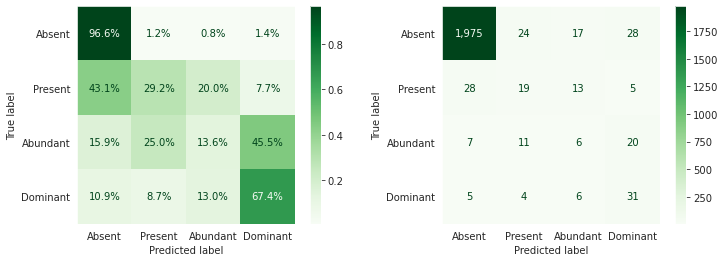

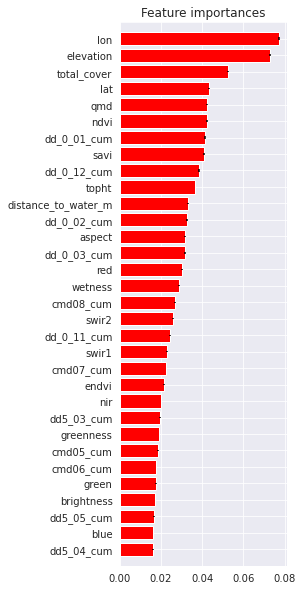

In [85]:
SP_NAME, MOD_TYPE = 'PONDEROSA_PINE', 'rf' 

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.441 ... 0.459 .....
@ sample iteration 11
..........
@ sample iteration 21
.....Done. 
Model saved at ../models/composition/sklearn_tuned/LODGEPOLE_PINE_rf_tuned.pkl



/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   pre       rec       spe        f1       geo       iba       sup

     absent       0.99      0.94      0.69      0.97      0.81      0.67      2128
    present       0.19      0.63      0.94      0.29      0.77      0.57        51
   abundant       0.00      0.00      1.00      0.00      0.00      0.00        12
   dominant       0.00      0.00      1.00      0.00      0.00      0.00         8

avg / total       0.96      0.93      0.70      0.94      0.80      0.66      2199



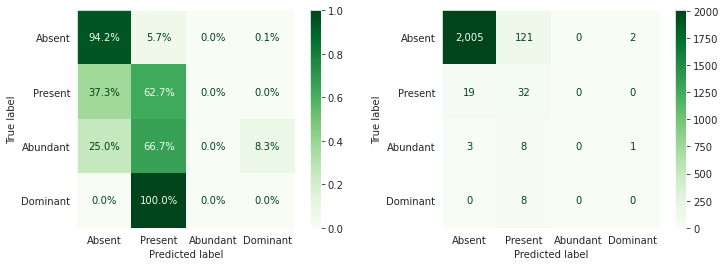

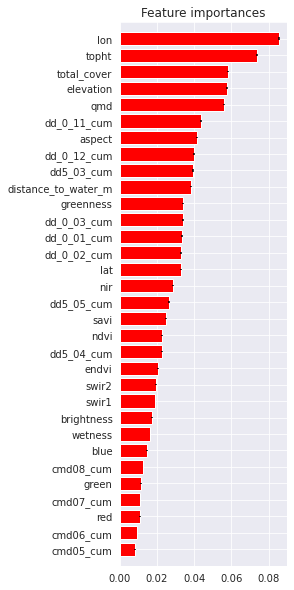

In [86]:
SP_NAME, MOD_TYPE = 'LODGEPOLE_PINE', 'rf' 

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.412  0.444 ........
@ sample iteration 11
....... 0.446 ..
@ sample iteration 21
.....Done. 
Model saved at ../models/composition/sklearn_tuned/OAK_rf_tuned.pkl

                   pre       rec       spe        f1       geo       iba       sup

     absent       0.99      0.98      0.69      0.99      0.83      0.70      2121
    present       0.59      0.66      0.98      0.62      0.81      0.63        74
   abundant       0.00      0.00      1.00      0.00      0.00      0.00         3
   dominant       0.00      0.00      1.00      0.00      0.00      0.00         1

avg / total       0.97      0.97      0.70      0.97      0.82      0.70      2199



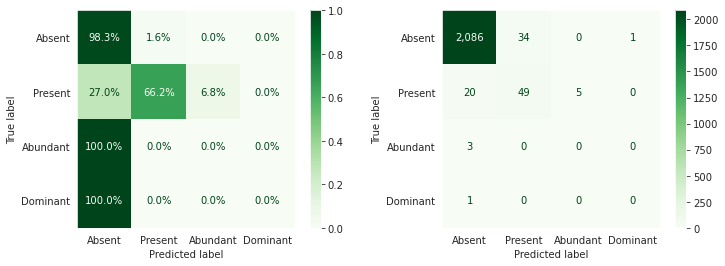

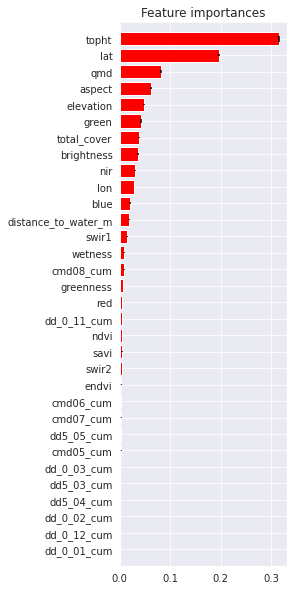

In [87]:
SP_NAME, MOD_TYPE = 'OAK', 'rf' 

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.458 . 0.470  0.521 ... 0.536 ..
@ sample iteration 11
 0.546 ...... 0.560  0.560  0.573 
@ sample iteration 21
... 0.573  0.573 Done. 
Model saved at ../models/composition/sklearn_tuned/JUNIPER_rf_tuned.pkl

                   pre       rec       spe        f1       geo       iba       sup

     absent       1.00      0.99      1.00      1.00      1.00      0.99      2196
    present       0.07      1.00      0.99      0.12      1.00      0.99         1
   abundant       1.00      1.00      1.00      1.00      1.00      1.00         2

avg / total       1.00      0.99      1.00      1.00      1.00      0.99      2199



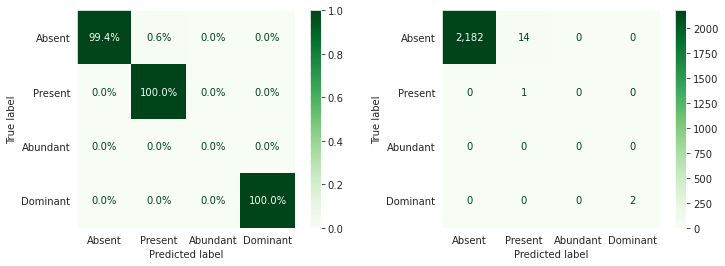

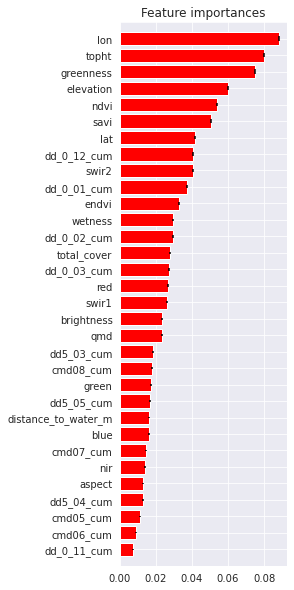

In [88]:
SP_NAME, MOD_TYPE = 'JUNIPER', 'rf' 

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.376 .. 0.388 ......
@ sample iteration 11
..........
@ sample iteration 21
.....Done. 
Model saved at ../models/composition/sklearn_tuned/SPRUCE_rf_tuned.pkl

                   pre       rec       spe        f1       geo       iba       sup

     absent       0.97      0.96      0.53      0.96      0.71      0.53      2064
    present       0.34      0.35      0.97      0.35      0.58      0.32        94
   abundant       0.15      0.43      0.98      0.23      0.65      0.40        14
   dominant       0.09      0.07      0.99      0.08      0.27      0.07        27

avg / total       0.93      0.92      0.56      0.92      0.70      0.52      2199



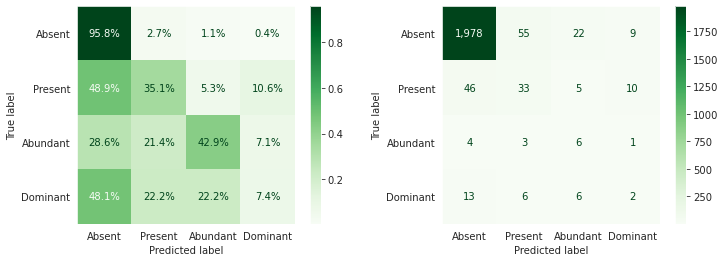

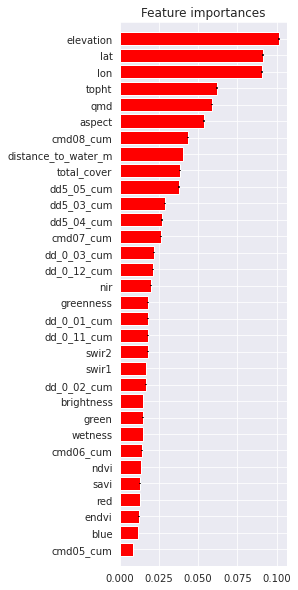

In [89]:
SP_NAME, MOD_TYPE = 'SPRUCE', 'rf' 

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.422 . 0.447 .... 0.486 . 0.487 
@ sample iteration 11
........ 0.491 .
@ sample iteration 21
.....Done. 
Model saved at ../models/composition/sklearn_tuned/TANOAK_rf_tuned.pkl

                   pre       rec       spe        f1       geo       iba       sup

     absent       1.00      0.97      0.99      0.98      0.98      0.96      2101
    present       0.44      0.96      0.96      0.60      0.96      0.92        71
   abundant       0.50      0.07      1.00      0.13      0.27      0.07        27
   dominant       0.00      0.00      1.00      0.00      0.00      0.00         0

avg / total       0.98      0.96      0.99      0.96      0.97      0.95      2199



/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


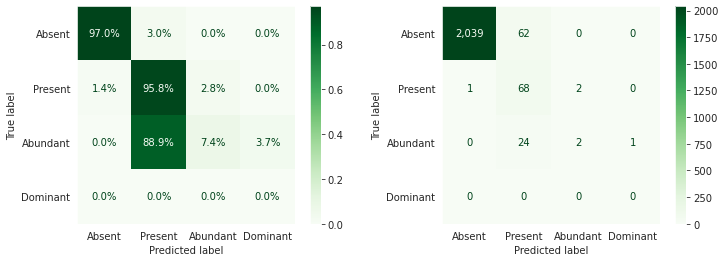

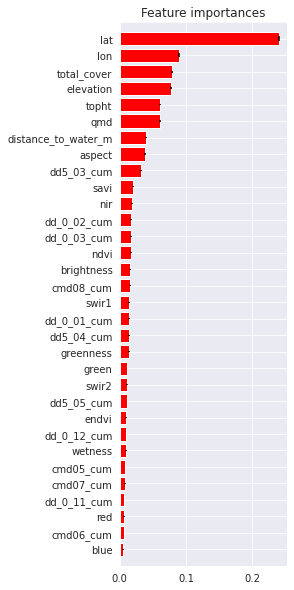

In [90]:
SP_NAME, MOD_TYPE = 'TANOAK', 'rf' 

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.376 .... 0.389 ....
@ sample iteration 11
..........
@ sample iteration 21
.....Done. 
Model saved at ../models/composition/sklearn_tuned/LARCH_rf_tuned.pkl

                   pre       rec       spe        f1       geo       iba       sup

     absent       0.98      0.97      0.69      0.98      0.82      0.69      2084
    present       0.41      0.71      0.97      0.52      0.83      0.67        66
   abundant       0.22      0.14      0.99      0.17      0.38      0.13        28
   dominant       0.50      0.10      1.00      0.16      0.31      0.09        21

avg / total       0.95      0.94      0.70      0.95      0.81      0.67      2199



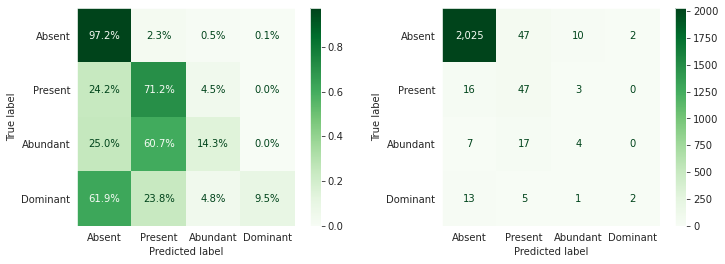

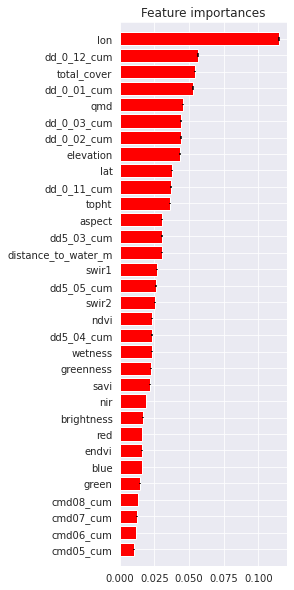

In [91]:
SP_NAME, MOD_TYPE = 'LARCH', 'rf' 

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.317 .. 0.318  0.319 .... 0.324 
@ sample iteration 11
...... 0.333 ...
@ sample iteration 21
.....Done. 
Model saved at ../models/composition/sklearn_tuned/OTHER_HARDWOOD_rf_tuned.pkl

                   pre       rec       spe        f1       geo       iba       sup

     absent       0.92      0.78      0.71      0.84      0.74      0.55      1762
    present       0.33      0.59      0.78      0.43      0.68      0.45       339
   abundant       0.18      0.11      0.98      0.14      0.33      0.10        71
   dominant       0.19      0.41      0.98      0.26      0.63      0.38        27

avg / total       0.79      0.72      0.73      0.75      0.72      0.52      2199



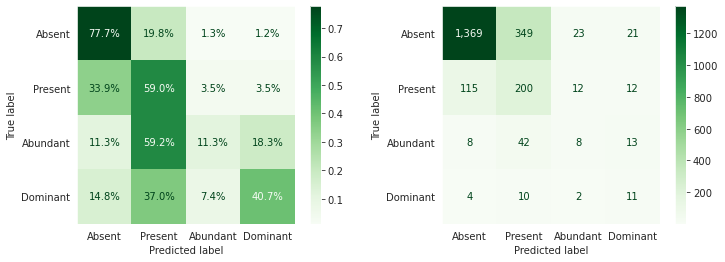

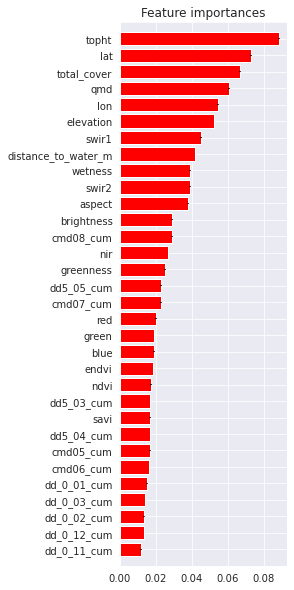

In [92]:
SP_NAME, MOD_TYPE = 'OTHER_HARDWOOD', 'rf' 

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.259 .........
@ sample iteration 11
..........
@ sample iteration 21
.. 0.261 ..Done. 
Model saved at ../models/composition/sklearn_tuned/OTHER_SOFTWOOD_rf_tuned.pkl



/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   pre       rec       spe        f1       geo       iba       sup

     absent       0.97      0.93      0.39      0.95      0.60      0.38      2109
    present       0.18      0.43      0.93      0.26      0.63      0.38        81
   abundant       0.00      0.00      1.00      0.00      0.00      0.00         9

avg / total       0.94      0.90      0.41      0.92      0.60      0.38      2199



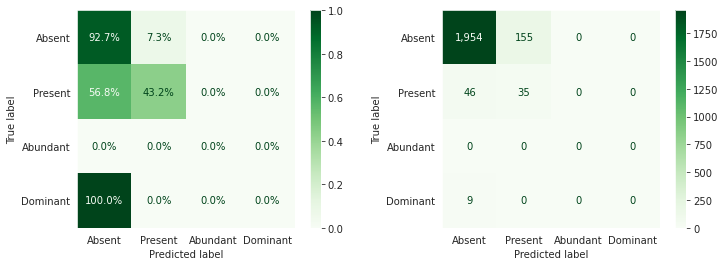

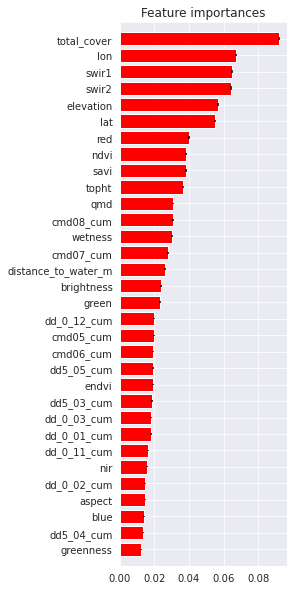

In [93]:
SP_NAME, MOD_TYPE = 'OTHER_SOFTWOOD', 'rf' 

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])